First we load in the loneliness data, a loneliness score is given for each MSOA (Middle Layer Super Output Area). Since we plan to compare to Ofsted school data which is given for local authorities we combine MSOAs

In [179]:
import pandas as pd

loneliness_data = pd.read_csv("msoa_loneliness.csv")
msoa_la_code_df = pd.read_csv('PCD_OA_LSOA_MSOA_LAD_FEB22_UK_LU.csv', encoding='latin-1') #change encoding to fix read error
#get LA code from msoa code
msoa_code_rows = msoa_la_code_df.loc[msoa_la_code_df['msoa11cd'].isin(loneliness_data['msoa11cd'])]
msoa_code_conv = dict(zip(msoa_code_rows['msoa11cd'],msoa_code_rows['ladcd']))
loneliness_data['LA code'] = loneliness_data['msoa11cd'].apply(lambda x: msoa_code_conv[x])
#print(loneliness_data)

LA_counts = loneliness_data.groupby('LA code').count()
LA_index_sum = loneliness_data.groupby('LA code').sum()['loneills_2018']
LA_index_average = LA_index_sum / LA_counts['msoa11cd']


# 1st attempted to merge by name - better to use LA codes

#perform the grouping by the local authority names of the msoas
# loneliness_data['msoa11nm']  = loneliness_data['msoa11nm'].str[:-4] # Strip numbers off names
# LA_counts = loneliness_data.groupby('msoa11nm').count()
# LA_index_sum = loneliness_data.groupby('msoa11nm').sum()['loneills_2018']
# LA_index_average = LA_index_sum / LA_counts['msoa11cd']

lonely_index_average = LA_index_average.rename('lonely_avg').to_frame()
print(lonely_index_average)# loneliness index average for each LA



C:\Users\Jonathan\AppData\Local\Temp/ipykernel_30284/4118828291.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  msoa_la_code_df = pd.read_csv('PCD_OA_LSOA_MSOA_LAD_FEB22_UK_LU.csv', encoding='latin-1') #change encoding to fix read error


           lonely_avg
LA code              
E06000001   -0.542761
E06000002    1.316155
E06000003    0.649266
E06000004    0.635474
E06000005    0.967079
...               ...
E09000029    0.922554
E09000030   -1.569304
E09000031   -0.738428
E09000032    0.855884
E09000033    0.243843

[309 rows x 1 columns]


We now get migration data for each local authority, we will sum migration in and out as both represent changes in people living in the area. We note the migration data is estimated by the ONS.

In [185]:
migration_data = pd.read_excel('laandregionssex5age2018newboundaries.xlsx', sheet_name=3, header=6)
print(migration_data.head(5))
# use ages 5-9 and 10-14 for school data 
ages = ['5-9','10-14']
#Inflow.1 is male, Inflow.2 is female
migration_school_ages = migration_data[migration_data['Age'].isin(ages)]
migration_school_ages = migration_school_ages.groupby('LA code').sum()
migration_school_ages['TotalFlow'] = migration_school_ages['Inflow'] + migration_school_ages['Outflow']
print(migration_school_ages.head(5))


     LA code     LA name    Age  Inflow  Outflow  Net  Inflow.1  Outflow.1  \
0  E06000001  Hartlepool    0-4     179      188   -9        92         86   
1  E06000001  Hartlepool    5-9     189      134   55        96         77   
2  E06000001  Hartlepool  10-14     124      147  -23        57         77   
3  E06000001  Hartlepool  15-19     153      380 -227        57        167   
4  E06000001  Hartlepool  20-24     518      475   43       228        217   

   Net.1  Inflow.2  Outflow.2  Net.2  
0      6        87        102    -15  
1     19        93         57     36  
2    -20        67         70     -3  
3   -110        96        213   -117  
4     11       290        258     32  
           Inflow  Outflow  Net  Inflow.1  Outflow.1  Net.1  Inflow.2  \
LA code                                                                 
E06000001     313      281   32       153        154     -1       160   
E06000002     544      734 -190       294        366    -72       250   
E0600

In [221]:
#get the school data
ofsted_df = pd.read_csv('OFSTED\england_school_information.csv',header=0)
#remove international schools (overseas territories)
ofsted_df = ofsted_df.loc[ofsted_df['LA'] != 704]
ofsted_df = ofsted_df.loc[ofsted_df['LA'] != 702]

area_conversion = pd.read_excel('nlac-2011.xls',header=0)
old2newLA = dict(zip(area_conversion['Old LA Code'],area_conversion['LA Name']))
#Fix changes to LA codes since 2011
old2newLA[838] = 'Dorset'
old2newLA[839] = 'Bournemouth, Christchurch & Poole'
old2newLA[941] = 'West Northamptonshire'
old2newLA[940] = 'North Northamptonshire'
ofsted_df['LA name']  = ofsted_df['LA'].apply(lambda x : old2newLA[x])

old2newLAcode = dict(zip(area_conversion['Old LA Code'],area_conversion['New LA Code']))
#Fix changes to LA codes since 2011
old2newLAcode[838] = 'E06000059'
old2newLAcode[839] = 'E06000058'
old2newLAcode[941] = 'E10000021'
old2newLAcode[940] = 'E10000021'
ofsted_df['New LA']  = ofsted_df['LA'].apply(lambda x : old2newLAcode[x])

#remove schools without ofsted rating
ofsted_df = ofsted_df.loc[ofsted_df['OFSTEDRATING'] != '']
ofsted_df = ofsted_df.loc[ofsted_df['OFSTEDRATING'].notna()]
ofsted_df = ofsted_df.loc[ofsted_df['OFSTEDRATING'] != 'Insufficient evidence']

rating_conversion = {'Outstanding' : 4, 'Good' : 3,'Requires improvement': 2, 'Inadequate' : 1, 'Serious Weaknesses': 1, 'Special Measures': 1}
ofsted_df['OFSTEDRATING'] = ofsted_df['OFSTEDRATING'].apply(lambda x: rating_conversion[x])
ofsted_sum = ofsted_df.groupby('New LA').sum()
ofsted_count = ofsted_df.groupby('New LA').count()

ofsted_avg = (ofsted_sum['OFSTEDRATING'] / ofsted_count['LA']).rename('Ofsted Avg').to_frame()
#print(migration_school_ages['LA code'])
print(ofsted_avg.head())

           Ofsted Avg
New LA               
E06000001    3.000000
E06000002    2.955556
E06000003    2.791667
E06000004    3.085714
E06000005    2.894737


In [226]:
#Get LA population data 
pop_df = pd.read_excel('ukmidyearestimates20182019ladcodes.xls',sheet_name='MYE2-All',header=4)
pop_df = pop_df.loc[pop_df['Code'].isin(ofsted_avg.reset_index()['New LA'])]
pop_dict = dict(zip(pop_df['Code'],pop_df['All ages']))

     LA code  TotalFlow  Ofsted Avg  lonely_avg               LA name  \
0  E06000001        594    3.000000   -0.542761            Hartlepool   
1  E06000002       1278    2.955556    1.316155         Middlesbrough   
2  E06000003        899    2.791667    0.649266  Redcar and Cleveland   
3  E06000004       1284    3.085714    0.635474      Stockton-on-Tees   

   LA flow rate  
0      0.006371  
1      0.009093  
2      0.006576  
3      0.006511  
              TotalFlow  Ofsted Avg  lonely_avg  LA flow rate
TotalFlow      1.000000    0.126208   -0.281943      0.472770
Ofsted Avg     0.126208    1.000000    0.245764      0.084576
lonely_avg    -0.281943    0.245764    1.000000     -0.110149
LA flow rate   0.472770    0.084576   -0.110149      1.000000


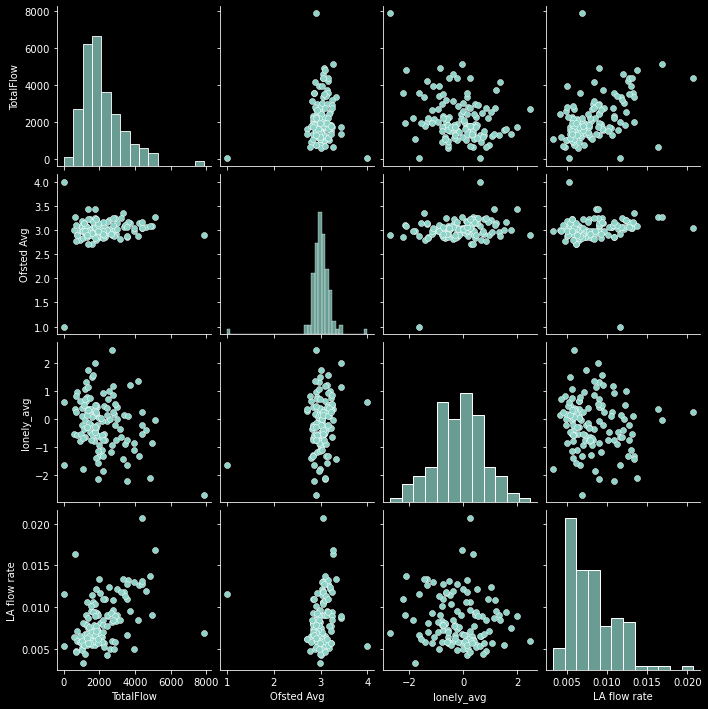

In [233]:
LAcodes_df = pd.read_csv('Local_Authority_Districts__December_2020__Names_and_Codes_in_the_United_Kingdom.csv',header=0)
LAcode2name = dict(zip(LAcodes_df['LAD20CD'],LAcodes_df['LAD20NM']))
#Add back abolished LAs
LAcode2name['E07000004'] = 'Aylesbury Vale'
LAcode2name['E07000005'] = 'Chiltern'
LAcode2name['E07000006'] = 'South Bucks'
LAcode2name['E07000007'] = 'Wycombe'

# Join the loneliness index with the migration data
main_df = migration_school_ages.join(ofsted_avg,on= 'LA code')
main_df = main_df.join(lonely_index_average, on='LA code')
main_df = main_df.reset_index()

main_df = main_df.loc[main_df['Ofsted Avg'].notna()] # remove LAs from wales etc which we havent calcualted Ofsted or lonely avg
main_df = main_df.loc[main_df['lonely_avg'].notna()]

main_df['LA name'] = main_df['LA code'].apply(lambda x: LAcode2name[x])
main_df['LA flow rate'] =  main_df['TotalFlow'] / main_df['LA code'].apply(lambda x: pop_dict[x])




# main_data['lonely_avg'] = pd.to_numeric(main_data['lonely_avg'])
main_vars = main_df.drop(columns=['Net', 'Inflow.1', 'Outflow.1', 'Net.1', 'Inflow.2','Outflow.2','Net.2'])
main_vars = main_vars.drop(columns=['Inflow', 'Outflow'])
print(main_vars.head(4))
print(main_vars.corr())

import seaborn as sns
import matplotlib
matplotlib.style.use('dark_background')
sns.pairplot(main_vars)

We can see there is a negative correlation between average loneliness and total migration flow of school age people.
There is a positive correlation between avg ofsted rating and total migration flow 
Perhaps higher total flow seems to coincide with lower loneliness index